# Testing Regularized Regression
I am curious about learning more about different types of regularlized regression. This notebook trys to look at the mechanics of them. Specifically around L1, L2, and elastic net logistic regression techniques.

In [1]:
# Some data preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 500
df = pd.read_csv("data/train.csv")
df["Cabin"] = df["Cabin"].str.slice(0, 1)
df = df.drop(labels=["PassengerId", "Name", "Ticket"], axis=1)
char_vars = df.select_dtypes("object").columns
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [2]:
df.loc[:,char_vars]  = df.loc[:,char_vars].apply(lambda x: x.astype("category").cat.codes)
df = df.fillna(value=-1)
df = df.apply(lambda x: x.replace({-1: np.around(x[x.ge(0)].mean())}))
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,2.0,2.0
1,1,1,0,38.0,1,0,71.2833,2.0,0.0
2,1,3,0,26.0,0,0,7.9250,2.0,2.0
3,1,1,0,35.0,1,0,53.1000,2.0,2.0
4,0,3,1,35.0,0,0,8.0500,2.0,2.0


In [3]:
df.shape

(891, 9)

## Good Ol' Linear Regression
First we will use standard regression with gradient descent as a starting point that we can tweak.  
Some good articles:  
[frossard/linear_regression](https://www.cs.toronto.edu/~frossard/post/linear_regression/)  
[numpy linear regression](https://towardsdatascience.com/linear-regression-from-scratch-with-numpy-implementation-finally-8e617d8e274c)


In [4]:
y = df.Survived.to_numpy()
X = df.drop(labels="Survived", axis=1).to_numpy()

In [5]:
# Standardize
x_sd = np.std(X, axis=0)
x_mean = np.mean(X, axis=0)
X = X - x_mean
X = X / x_sd

**Just Using Matrix Linear Algebra**
This is the vanilla OLS matrix algebrea formula that is intoduced in every intro econometrics/statistics course.
$$Y = X\beta + \epsilon$$
Where the solution for $\beta$ is:
$$\beta = (X^{T}X)^{-1}X^{T}Y$$

In [6]:
# With matrix operations
# Note this is not logistic regression, just regular ols
X_r = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
XtX_inv = np.linalg.inv(np.matmul(X_r.transpose(),X_r))
Xty = np.matmul(X_r.transpose(),y)
beta_hat_ols = np.matmul(XtX_inv, Xty)

In [7]:
pd.DataFrame({"Var": ["Intercept"] + df.columns.to_list()[1:], "Coef": beta_hat_ols})

,Var,Coef
0,Intercept,0.383838
1,Pclass,-0.139091
2,Sex,-0.239957
3,Age,-0.074592
4,SibSp,-0.045274
5,Parch,-0.014452
6,Fare,0.017858
7,Cabin,0.026093
8,Embarked,-0.030106


## Logistic Rregression with Gradient Descent
Finally what we have all been waiting for Logistic regression with gradient descent, the workhorse of the modern data scientist.
$$h_{\theta}(x) = g(\theta^{T}x)$$
$$z = \theta^{T}X$$
$$g(z) = \frac{1}{1+e^{-z}}$$
Loss function:
$$h = g(X\theta)$$
$$J(\theta) = \frac{1}{m}.(-y^{T} log(h) - (1 - y)^{T} log(1-h))$$

Here is a helpful document:  
[Logistic regression explanation](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html)

In [8]:
class LogisticReg:
    """Simple logistic regression class.
       Assumes the intercept is currently on the data."""
    def __init__(self,
                 n_iter=10000,
                 eta=0.05,
                 standardize=True,
                 add_intercept=True,
                 seed=0):

        self.n_iter = n_iter
        self.eta = eta
        self.mod_fit = False
        self.standardize = standardize
        self.add_intercept = add_intercept
        self.iterations = 0
        self.seed = seed
        self.theta = None
    
    def _add_intercept(self, X):
        if self.add_intercept:
            X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
        return X

    @staticmethod
    def _sgmd(z):
        return 1.0 / (1 + np.exp(-z))

    def z(self, X):
        """Predict logit"""
        return np.dot(X, self.theta)

    def predict(self, X):
        """External predict to be called after model is fit."""
        if not self.mod_fit:
            print("Model not yet fit.")
            return None
        if self.add_intercept:
            X = self._add_intercept(X)
        return self._predict(X)

    def _predict(self, X):
        """Predict Probability"""
        return self._sgmd(self.z(X))

    def cost_function(self, preds, X, y):
        """Calculate cost function"""
        one_cost = np.dot(np.transpose(-y), np.log(preds))
        zero_cost = np.dot(np.transpose(1 - y), np.log(1 - preds))
        return np.sum(one_cost - zero_cost)/X.shape[0]

    def gradient(self, preds, X, y):
        grad = np.dot(np.transpose(X), (preds - y)) / X.shape[0]
        return grad

    def gradient_descent(self, X, y, tol):
        # Init theta
        prev_cost = np.Inf
        for i in range(0, self.n_iter):
            self.iterations += 1
            preds = self._predict(X)
            cost = self.cost_function(preds, X, y)
            if np.isnan(cost):
                print("Function did not converge. \n" +
                      "Consider a lower ETA, or standardizing your data.")
                break
            self.eval_history[i] = cost
            grad = self.gradient(preds, X, y)
            self.theta -= grad*self.eta
            if (prev_cost - cost) < tol:
                self.eval_history = self.eval_history[0:self.iterations]
                break
            prev_cost = cost

    def fit(self, X, y, tol=0.001):
        self.mod_fit = True
        X = self._add_intercept(X)
        if self.theta is None:
            self.theta = np.zeros(X.shape[1])
        self.eval_history = np.ones(self.n_iter)
        self.gradient_descent(X, y, tol)


In [9]:
mod = LogisticReg(eta=0.01)
mod.fit(X, y)

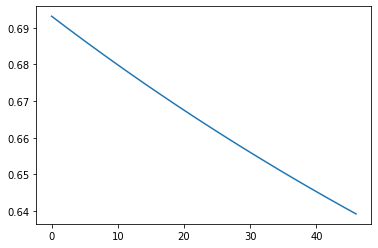

In [10]:
p = sns.lineplot(x=range(0,len(mod.eval_history)), y=mod.eval_history)

In [11]:
pd.DataFrame({"Var": ["Intercept"] + df.columns.to_list()[1:], "Coef_1": beta_hat_ols, "Coef_2": mod.theta})

,Var,Coef_1,Coef_2
0,Intercept,0.383838,-0.051572
1,Pclass,-0.139091,-0.070556
2,Sex,-0.239957,-0.115728
3,Age,-0.074592,-0.016267
4,SibSp,-0.045274,-0.008975
5,Parch,-0.014452,0.015545
6,Fare,0.017858,0.051799
7,Cabin,0.026093,0.017434
8,Embarked,-0.030106,-0.034312


## Extending Logistic Regression with Ridge Regression
Let's take a look at extending out simple example, but this time using ridge regression.

In [188]:
class RidgeRegression(LogisticReg):
    def __init__(self, penalty_term=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.penalty_term = penalty_term

    def gradient(self, preds, X, y):
        theta_grad = np.dot(np.transpose(X), (preds - y)) / X.shape[0]
        if self._add_intercept:
            penalty_grad =  self.penalty_term * self.theta[1:] / X.shape[0]
            penalty_grad = np.insert(penalty_grad, 0, 0)
        else:
            penalty_grad = self.penalty_term * self.theta[1:] / X.shape[0]
        return theta_grad + penalty_grad
        
    def cost_function(self, preds, X, y):
        """Calculate cost function"""
        one_cost = np.dot(np.transpose(-y), np.log(preds))
        zero_cost = np.dot(np.transpose(1 - y), np.log(1 - preds))
        penalty_cost = (1/X.shape[0]) * np.sum(np.square(self.theta))
        return (np.sum(one_cost - zero_cost) / X.shape[0]) + penalty_cost

In [189]:
rdtest = RidgeRegression(add_intercept=True, penalty_term = 0.1)
rdtest.fit(X, y)

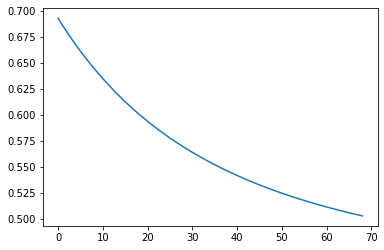

In [190]:
p = sns.lineplot(x=range(0,len(rdtest.eval_history)), y=rdtest.eval_history)

In [191]:
pd.DataFrame({"Var": ["Intercept"] + df.columns.to_list()[1:], "Coef_1": beta_hat_ols, "Coef_2": mod.theta,
"Coef_3": rdtest.theta})

,Var,Coef_1,Coef_2,Coef_3
0,Intercept,0.383838,-0.051572,-0.272673
1,Pclass,-0.139091,-0.070556,-0.327499
2,Sex,-0.239957,-0.115728,-0.584515
3,Age,-0.074592,-0.016267,-0.112949
4,SibSp,-0.045274,-0.008975,-0.079109
5,Parch,-0.014452,0.015545,0.033435
6,Fare,0.017858,0.051799,0.198885
7,Cabin,0.026093,0.017434,0.090254
8,Embarked,-0.030106,-0.034312,-0.141776


In [212]:
n_iter = 5000
coef_mat = np.zeros((n_iter, 9))
reg_var = np.linspace(-2, 10, n_iter)
mod_coefs = np.zeros(X.shape[1] + 1)
for i in range(0, n_iter):
    md = RidgeRegression(add_intercept=True, penalty_term = np.exp(reg_var[i]))
    md.theta = mod_coefs
    md.fit(X, y, tol=1e-8)
    mod_coefs = md.theta
    coef_mat[i,:] = md.theta

In [213]:
md.theta[0]

-0.4733299359428685

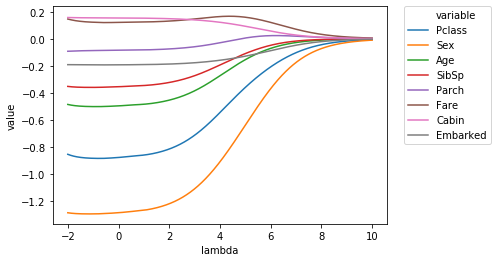

In [214]:
c_df = pd.DataFrame(coef_mat[:,1:])
#c_df.columns = ["Intercept"] + df.columns.to_list()[1:]
c_df.columns = df.columns.to_list()[1:]
c_df['lambda'] = reg_var
c_df = c_df.melt(["lambda"])
p = sns.lineplot(x="lambda", y="value", hue="variable", data=c_df)
p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Lets look at the same plot, but created using the sklearn implementation of Ridge classification.

In [215]:
from sklearn import linear_model as lm

In [216]:
n_iter = 1000
coef_mat_ridgeskl = np.zeros((n_iter, 8))
reg_var = np.linspace(-2, 10, n_iter)
for i in range(0, n_iter):
    # md = lm.RidgeClassifier(alpha=np.exp(reg_var[i]))
    md = lm.LogisticRegression(penalty="l2", C=1/np.exp(reg_var[i]))
    md.fit(X, y)
    coef_mat_ridgeskl[(i),:] = md.coef_

In [217]:
md.intercept_

array([-0.47332165])

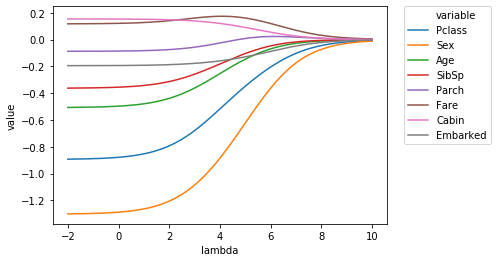

In [218]:
c_df = pd.DataFrame(coef_mat_ridgeskl)
#c_df.columns = ["Intercept"] + df.columns.to_list()[1:]
c_df.columns = df.columns.to_list()[1:]
c_df['lambda'] = reg_var
c_df = c_df.melt(["lambda"])
p = sns.lineplot(x="lambda", y="value", hue="variable", data=c_df)
p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The scikit-learn implementation is so much faster. This is largely because the entire coordinate descent code is writen in cython. 

## Lasso (L1 Regularlization)

Consider that $f(x)=|x| = \sqrt{x^{2}}$

In [21]:
x_exmp = np.linspace(-10.0, 10.0, 100)
y_exmp = np.sqrt(x_exmp ** 2)

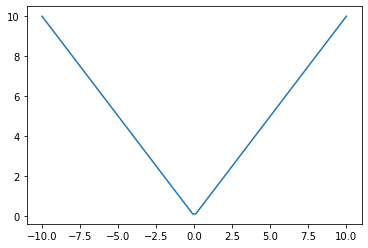

In [22]:
p = sns.lineplot(x=x_exmp, y=y_exmp)

The derivative of this function is $\frac{\delta f(x)}{\delta x} = \frac{x}{|x|}$

In [23]:
y_exmp_dlta = x_exmp / np.absolute(x_exmp)

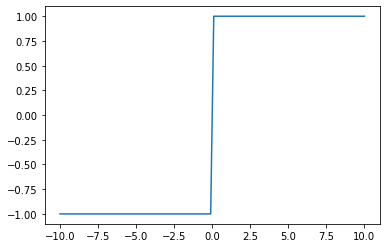

In [24]:
p = sns.lineplot(x=x_exmp, y=y_exmp_dlta)

The question is what to do when $x = 0$ which is undefinded for our funciton $\frac{x}{|x|}$.
For now we can just set is equal to zero.

We need a mechanism that checks if a coefficient is going to flip signs it is set to zero.
We could do this, by saving the sign of the previous rounds coefficient. than if it has changed, set the coefficient to 0.

In [431]:
class LassoRegression(LogisticReg):
    def __init__(self, penalty_term=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.penalty_term = penalty_term

    def gradient(self, preds, X, y):
        theta_grad = np.dot(np.transpose(X), (preds - y)) / X.shape[0]
        if self._add_intercept:
            penalty_grad = self.penalty_term * np.sign(self.theta[1:]) / X.shape[0]
            penalty_grad = np.insert(penalty_grad, 0, 0)
        else:
            penalty_grad = self.penalty_term * np.sign(self.theta) / X.shape[0]
        return theta_grad + penalty_grad
            
    def cost_function(self, preds, X, y):
        """Calculate cost function"""
        one_cost = np.dot(np.transpose(-y), np.log(preds))
        zero_cost = np.dot(np.transpose(1 - y), np.log(1 - preds))
        penalty_cost = np.sum(np.abs(self.theta))
        return (np.sum(one_cost - zero_cost) + self.penalty_term * penalty_cost)/X.shape[0]

    def gradient_descent(self, X, y, tol):
        # Init theta
        theta_hist = np.zeros(X.shape[1])
        prev_cost = np.Inf
        zero_mask = np.repeat(False, X.shape[1])
        for i in range(0, self.n_iter):
            self.iterations += 1
            preds = self._predict(X)
            cost = self.cost_function(preds, X, y)
            if np.isnan(cost):
                print("Function did not converge. \n" +
                      "Consider a lower ETA, or standardizing your data.")
                break
            self.eval_history[i] = cost
            grad = self.gradient(preds, X, y)
            self.theta -= grad*self.eta

            # zero_mask[np.abs(self.theta) < 0.002] = True
            
            # self.theta[zero_mask] = 0

            if (prev_cost - cost) < tol:
                self.eval_history = self.eval_history[0:self.iterations]
                break
            prev_cost = cost


In [453]:
latest = LassoRegression(add_intercept=True, n_iter=10000, penalty_term = 1)
latest.fit(X, y, tol=0.00001)

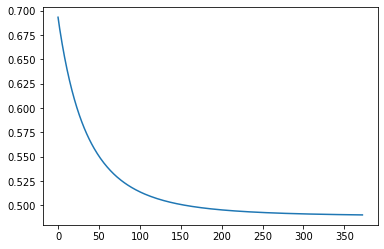

In [443]:
p = sns.lineplot(x=range(0,len(latest.eval_history)), y=latest.eval_history)

In [444]:
n_runs = 1000
coef_mat_lasso = np.zeros((n_runs, 9))
reg_var = np.linspace(-2, 6, n_runs)
coef_init = np.zeros(X.shape[1] + 1)
for i in range(0, n_runs):
    md = LassoRegression(add_intercept=True, 
                         penalty_term = np.exp(reg_var[i]), n_iter=10000)
    md.theta = coef_init
    md.fit(X, y, tol=1e-7)
    coef_init = md.theta
    coef_mat_lasso[i,:] = md.theta

In [440]:
md.theta[0]

-0.4770474309679738

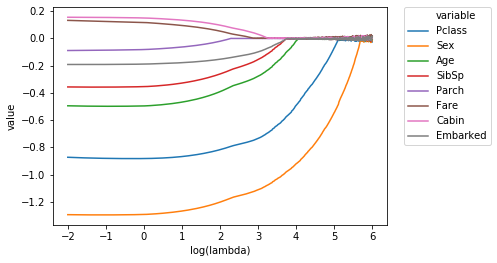

In [441]:
c_df = pd.DataFrame(coef_mat_lasso[:,1:])
#c_df.columns = ["Intercept"] + df.columns.to_list()[1:]
c_df.columns = df.columns.to_list()[1:]
c_df['log(lambda)'] = reg_var
c_df = c_df.melt(["log(lambda)"])
p = sns.lineplot(x="log(lambda)", y="value", hue="variable", data=c_df)
p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

It looks like this is working alright.  
I am not getting the forcing coefficients to zero part correct...  
I will have to look into this more.

In [457]:
n_runs = 1000
coef_mat_lasso = np.zeros((n_runs, 8))
reg_var = np.linspace(-2, 6, n_runs)
coef_init = np.zeros(X.shape[1] + 1)
md = lm.LogisticRegression(penalty="l1", max_iter=int(1e6), tol=0.0001, solver="saga", warm_start=True)
for i in range(0, n_runs):
    md = md.set_params(C=1/np.exp(reg_var[i]))
    md.fit(X, y)
    coef_mat_lasso[i,:] = md.coef_

In [458]:
md.intercept_

array([-0.48140145])

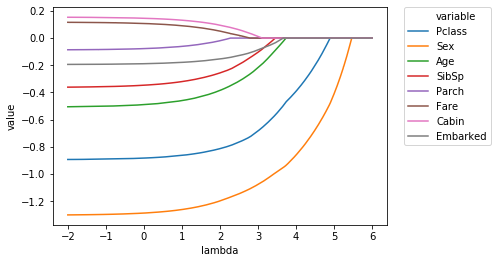

In [459]:
c_df = pd.DataFrame(coef_mat_lasso)
#c_df.columns = ["Intercept"] + df.columns.to_list()[1:]
c_df.columns = df.columns.to_list()[1:]
c_df['lambda'] = reg_var
c_df = c_df.melt(["lambda"])
p = sns.lineplot(x="lambda", y="value", hue="variable", data=c_df)
p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)